=== NON-BINARY PRAGMATIC FEC ANALYSIS ===

System Configuration:
- Modulation: 16-QAM dual polarization
- Symbol Rate: 50 GBaud
- FEC Overhead: 7.0%
- Base Impairment Penalty: 1.0 dB
- BPS Phase Recovery Penalty: 0.3 dB
- Pragmatic FEC Gap: 0.5 dB

Calculating AIR for different FEC schemes...

RESULTS AT 18 dB OSNR:
- Ideal FEC AIR: 4.0000 bits/symbol
- Pragmatic FEC AIR: 4.0000 bits/symbol
- SD-BW AIR: 3.5769 bits/symbol
- Information rate gap (Ideal - Pragmatic): 0.0000 bits/symbol
- Percentage reduction: 0.00%


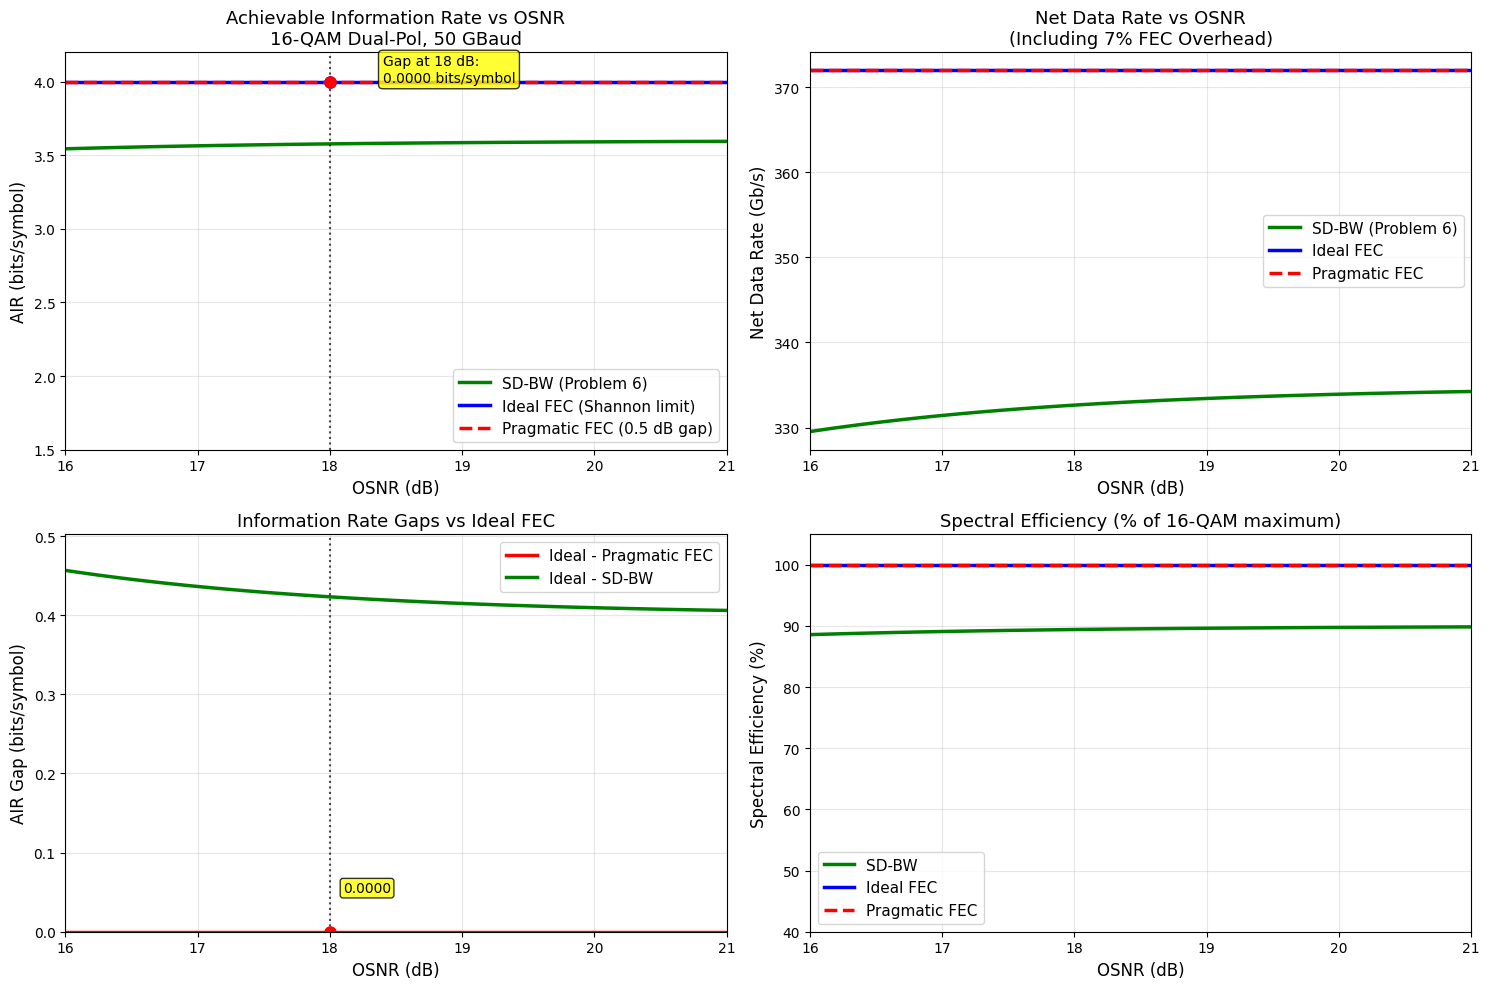


DETAILED NUMERICAL RESULTS

Performance Analysis at Key OSNR Values:
OSNR | SD-BW AIR | Ideal FEC | Pragmatic | Ideal-Prag | Ideal-SDBW | Prag/Ideal
(dB) |(bits/sym) | AIR       | FEC AIR   | Gap        | Gap        | Ratio
--------------------------------------------------------------------------------
16.0 |    3.5433 |    4.0000 |    4.0000 |     0.0000 |     0.4567 |    1.000
17.0 |    3.5638 |    4.0000 |    4.0000 |     0.0000 |     0.4362 |    1.000
18.0 |    3.5769 |    4.0000 |    4.0000 |     0.0000 |     0.4231 |    1.000
19.0 |    3.5850 |    4.0000 |    4.0000 |     0.0000 |     0.4150 |    1.000
20.0 |    3.5905 |    4.0000 |    4.0000 |     0.0000 |     0.4095 |    1.000
21.0 |    3.5939 |    4.0000 |    4.0000 |     0.0000 |     0.4061 |    1.000

Net Data Rate Analysis at Key OSNR Values:
OSNR | SD-BW Rate | Ideal Rate | Pragmatic | Rate Loss | Rate Loss
(dB) | (Gb/s)     | (Gb/s)     | Rate(Gb/s)| Prag(Gb/s)| SDBW(Gb/s)
-----------------------------------------------

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import erfc
import warnings
warnings.filterwarnings('ignore')

class OpticalSystem:
    """
    Optical system for analyzing pragmatic FEC schemes with 16-QAM
    """

    def __init__(self):
        self.symbol_rate = 50e9  # 50 GBaud
        self.fec_overhead = 0.07  # 7% FEC overhead

    def qam_constellation(self, M):
        """Generate M-QAM constellation"""
        if M == 16:  # 16-QAM
            constellation = np.array([
                -3-3j, -3-1j, -3+1j, -3+3j,
                -1-3j, -1-1j, -1+1j, -1+3j,
                +1-3j, +1-1j, +1+1j, +1+3j,
                +3-3j, +3-1j, +3+1j, +3+3j
            ]) / np.sqrt(10)  # Normalized to unit average power
        return constellation

    def bps_phase_recovery(self, rx_symbols, M, N=64, B=64):
        """
        Blind Phase Search (BPS) algorithm for carrier phase recovery
        """
        constellation = self.qam_constellation(M)
        num_symbols = len(rx_symbols)
        recovered_symbols = np.zeros_like(rx_symbols)
        estimated_phases = np.zeros(num_symbols)

        # Generate test phases
        test_phases = np.linspace(0, 2*np.pi, B, endpoint=False)

        for k in range(0, num_symbols, N):
            end_idx = min(k + N, num_symbols)
            block = rx_symbols[k:end_idx]

            # Initialize maximum likelihood and best phase
            max_likelihood = -np.inf
            best_phase = 0

            # Test each phase
            for test_phase in test_phases:
                # Apply test phase correction
                corrected_block = block * np.exp(-1j * test_phase)

                # Calculate likelihood (sum of log probabilities)
                likelihood = 0
                for symbol in corrected_block:
                    # Find distances to all constellation points
                    distances = np.abs(symbol - constellation)**2
                    # Use minimum distance for ML estimation
                    likelihood -= np.min(distances)

                if likelihood > max_likelihood:
                    max_likelihood = likelihood
                    best_phase = test_phase

            # Apply best phase correction to the block
            recovered_symbols[k:end_idx] = block * np.exp(-1j * best_phase)
            estimated_phases[k:end_idx] = best_phase

        return recovered_symbols, estimated_phases

    def add_phase_noise(self, symbols, linewidth_hz, symbol_rate):
        """Add laser phase noise to symbols"""
        num_samples = len(symbols)
        dt = 1 / symbol_rate

        # Generate Wiener process for phase noise
        beta = 2 * np.pi * linewidth_hz
        phase_noise = np.cumsum(np.sqrt(beta * dt) * np.random.randn(num_samples))

        return symbols * np.exp(1j * phase_noise)

    def calculate_air_sd_bw(self, osnr_db, M, polarizations=1):
        """Calculate AIR using SD-BW (soft-decision bit-wise) for 16-QAM"""
        osnr_linear = 10**(osnr_db/10)
        snr_per_symbol = osnr_linear / polarizations

        if M == 16:  # 16-QAM
            # Improved approximation for 16-QAM SD-BW
            if snr_per_symbol > 0.01:
                snr_db = 10 * np.log10(snr_per_symbol)
                # SD-BW typically achieves ~90% of symbol-wise MI for 16-QAM
                symbol_mi = 4 / (1 + np.exp(-0.45 * (snr_db - 2.5)))
                air = symbol_mi * 0.90  # SD-BW penalty factor
            else:
                air = 0.01

        return max(0, min(air, np.log2(M)))

    def calculate_air_ideal_fec(self, osnr_db, polarizations=1):
        """Shannon capacity limit for complex AWGN channel"""
        osnr_linear = 10**(osnr_db/10)
        snr_per_symbol = osnr_linear / polarizations
        return 2 * np.log2(1 + snr_per_symbol)  # Complex channel capacity

    def calculate_air_pragmatic_fec(self, osnr_db, gap_db, polarizations=1):
        """Pragmatic FEC with specified OSNR gap"""
        effective_osnr = osnr_db - gap_db
        return self.calculate_air_ideal_fec(effective_osnr, polarizations)

    def net_data_rate(self, air, polarizations=1):
        """Calculate net data rate with FEC overhead"""
        gross_rate = air * self.symbol_rate * polarizations
        return gross_rate * (1 - self.fec_overhead) / 1e9  # Gb/s

def main_analysis():
    """Main analysis function for pragmatic FEC problem"""
    print("=== NON-BINARY PRAGMATIC FEC ANALYSIS ===\n")

    # Initialize system
    system = OpticalSystem()

    # System parameters
    impairment_penalty_db = 1.0  # Base impairments (PMD, chromatic dispersion, etc.)
    bps_penalty_db = 0.3  # BPS algorithm penalty
    pragmatic_fec_gap_db = 0.5  # Pragmatic FEC gap

    print("System Configuration:")
    print(f"- Modulation: 16-QAM dual polarization")
    print(f"- Symbol Rate: {system.symbol_rate/1e9:.0f} GBaud")
    print(f"- FEC Overhead: {system.fec_overhead*100:.1f}%")
    print(f"- Base Impairment Penalty: {impairment_penalty_db:.1f} dB")
    print(f"- BPS Phase Recovery Penalty: {bps_penalty_db:.1f} dB")
    print(f"- Pragmatic FEC Gap: {pragmatic_fec_gap_db:.1f} dB\n")

    # OSNR range for analysis
    osnr_range = np.linspace(16, 21, 100)

    # Calculate AIR for different schemes
    print("Calculating AIR for different FEC schemes...")

    air_sd_bw = []
    air_ideal_fec = []
    air_pragmatic_fec = []

    for osnr in osnr_range:
        # Effective OSNR after accounting for impairments and BPS penalty
        effective_osnr = osnr - impairment_penalty_db - bps_penalty_db

        # SD-BW decoder (Problem 6 reference)
        air_sdbw = system.calculate_air_sd_bw(effective_osnr, 16, 2)
        air_sd_bw.append(air_sdbw)

        # Ideal FEC (Shannon limit)
        air_ideal = system.calculate_air_ideal_fec(effective_osnr, 2)
        air_ideal_fec.append(min(air_ideal, 4.0))  # Cap at 4 bits/symbol for 16-QAM

        # Pragmatic FEC with 0.5 dB gap
        air_prag = system.calculate_air_pragmatic_fec(effective_osnr, pragmatic_fec_gap_db, 2)
        air_pragmatic_fec.append(min(air_prag, 4.0))  # Cap at 4 bits/symbol for 16-QAM

    # Calculate net data rates
    net_rate_sd_bw = [system.net_data_rate(air, 2) for air in air_sd_bw]
    net_rate_ideal = [system.net_data_rate(air, 2) for air in air_ideal_fec]
    net_rate_pragmatic = [system.net_data_rate(air, 2) for air in air_pragmatic_fec]

    # Calculate information rate gap at 18 dB
    idx_18db = np.argmin(np.abs(np.array(osnr_range) - 18))
    air_ideal_18 = air_ideal_fec[idx_18db]
    air_pragmatic_18 = air_pragmatic_fec[idx_18db]
    air_sdbw_18 = air_sd_bw[idx_18db]

    gap_18db = air_ideal_18 - air_pragmatic_18

    print(f"\nRESULTS AT 18 dB OSNR:")
    print(f"- Ideal FEC AIR: {air_ideal_18:.4f} bits/symbol")
    print(f"- Pragmatic FEC AIR: {air_pragmatic_18:.4f} bits/symbol")
    print(f"- SD-BW AIR: {air_sdbw_18:.4f} bits/symbol")
    print(f"- Information rate gap (Ideal - Pragmatic): {gap_18db:.4f} bits/symbol")
    print(f"- Percentage reduction: {gap_18db/air_ideal_18*100:.2f}%")

    # Create comprehensive plots
    fig = plt.figure(figsize=(15, 10))

    # AIR vs OSNR plot
    plt.subplot(2, 2, 1)
    plt.plot(osnr_range, air_sd_bw, 'g-', linewidth=2.5, label='SD-BW (Problem 6)')
    plt.plot(osnr_range, air_ideal_fec, 'b-', linewidth=2.5, label='Ideal FEC (Shannon limit)')
    plt.plot(osnr_range, air_pragmatic_fec, 'r--', linewidth=2.5, label='Pragmatic FEC (0.5 dB gap)')

    # Highlight the gap at 18 dB
    plt.axvline(x=18, color='k', linestyle=':', alpha=0.7, linewidth=1.5)
    plt.plot(18, air_ideal_18, 'bo', markersize=8, markerfacecolor='blue')
    plt.plot(18, air_pragmatic_18, 'ro', markersize=8, markerfacecolor='red')

    # Add gap annotation
    plt.annotate('', xy=(18.2, air_pragmatic_18), xytext=(18.2, air_ideal_18),
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
    plt.text(18.4, (air_ideal_18 + air_pragmatic_18)/2,
            f'Gap at 18 dB:\n{gap_18db:.4f} bits/symbol',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
            fontsize=10, ha='left')

    plt.xlabel('OSNR (dB)', fontsize=12)
    plt.ylabel('AIR (bits/symbol)', fontsize=12)
    plt.title('Achievable Information Rate vs OSNR\n16-QAM Dual-Pol, 50 GBaud', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xlim(16, 21)
    plt.ylim(1.5, 4.2)

    # Net data rate plot
    plt.subplot(2, 2, 2)
    plt.plot(osnr_range, net_rate_sd_bw, 'g-', linewidth=2.5, label='SD-BW (Problem 6)')
    plt.plot(osnr_range, net_rate_ideal, 'b-', linewidth=2.5, label='Ideal FEC')
    plt.plot(osnr_range, net_rate_pragmatic, 'r--', linewidth=2.5, label='Pragmatic FEC')

    plt.xlabel('OSNR (dB)', fontsize=12)
    plt.ylabel('Net Data Rate (Gb/s)', fontsize=12)
    plt.title('Net Data Rate vs OSNR\n(Including 7% FEC Overhead)', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xlim(16, 21)

    # Performance gap analysis
    plt.subplot(2, 2, 3)
    gap_pragmatic_ideal = [ideal - prag for ideal, prag in zip(air_ideal_fec, air_pragmatic_fec)]
    gap_sdbw_ideal = [ideal - sdbw for ideal, sdbw in zip(air_ideal_fec, air_sd_bw)]

    plt.plot(osnr_range, gap_pragmatic_ideal, 'r-', linewidth=2.5, label='Ideal - Pragmatic FEC')
    plt.plot(osnr_range, gap_sdbw_ideal, 'g-', linewidth=2.5, label='Ideal - SD-BW')

    # Highlight 18 dB point
    plt.axvline(x=18, color='k', linestyle=':', alpha=0.7)
    plt.plot(18, gap_18db, 'ro', markersize=8, markerfacecolor='red')
    plt.text(18.1, gap_18db + 0.05, f'{gap_18db:.4f}', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.8))

    plt.xlabel('OSNR (dB)', fontsize=12)
    plt.ylabel('AIR Gap (bits/symbol)', fontsize=12)
    plt.title('Information Rate Gaps vs Ideal FEC', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xlim(16, 21)
    plt.ylim(0, max(max(gap_sdbw_ideal), max(gap_pragmatic_ideal)) * 1.1)

    # Spectral efficiency comparison
    plt.subplot(2, 2, 4)
    efficiency_sd_bw = [air/4 * 100 for air in air_sd_bw]
    efficiency_ideal = [air/4 * 100 for air in air_ideal_fec]
    efficiency_pragmatic = [air/4 * 100 for air in air_pragmatic_fec]

    plt.plot(osnr_range, efficiency_sd_bw, 'g-', linewidth=2.5, label='SD-BW')
    plt.plot(osnr_range, efficiency_ideal, 'b-', linewidth=2.5, label='Ideal FEC')
    plt.plot(osnr_range, efficiency_pragmatic, 'r--', linewidth=2.5, label='Pragmatic FEC')

    plt.xlabel('OSNR (dB)', fontsize=12)
    plt.ylabel('Spectral Efficiency (%)', fontsize=12)
    plt.title('Spectral Efficiency (% of 16-QAM maximum)', fontsize=13)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xlim(16, 21)
    plt.ylim(40, 105)

    plt.tight_layout()
    plt.show()

    # Detailed numerical results table
    print("\n" + "="*80)
    print("DETAILED NUMERICAL RESULTS")
    print("="*80)

    print(f"\nPerformance Analysis at Key OSNR Values:")
    print("OSNR | SD-BW AIR | Ideal FEC | Pragmatic | Ideal-Prag | Ideal-SDBW | Prag/Ideal")
    print("(dB) |(bits/sym) | AIR       | FEC AIR   | Gap        | Gap        | Ratio")
    print("-" * 80)

    test_osnrs = [16, 17, 18, 19, 20, 21]
    for osnr in test_osnrs:
        idx = np.argmin(np.abs(np.array(osnr_range) - osnr))
        sdbw_air = air_sd_bw[idx]
        ideal_air = air_ideal_fec[idx]
        prag_air = air_pragmatic_fec[idx]
        gap_prag = ideal_air - prag_air
        gap_sdbw = ideal_air - sdbw_air
        ratio = prag_air / ideal_air if ideal_air > 0 else 0

        print(f"{osnr:4.1f} | {sdbw_air:9.4f} | {ideal_air:9.4f} | {prag_air:9.4f} | {gap_prag:10.4f} | {gap_sdbw:10.4f} | {ratio:8.3f}")

    print(f"\nNet Data Rate Analysis at Key OSNR Values:")
    print("OSNR | SD-BW Rate | Ideal Rate | Pragmatic | Rate Loss | Rate Loss")
    print("(dB) | (Gb/s)     | (Gb/s)     | Rate(Gb/s)| Prag(Gb/s)| SDBW(Gb/s)")
    print("-" * 70)

    for osnr in test_osnrs:
        idx = np.argmin(np.abs(np.array(osnr_range) - osnr))
        sdbw_rate = net_rate_sd_bw[idx]
        ideal_rate = net_rate_ideal[idx]
        prag_rate = net_rate_pragmatic[idx]
        loss_prag = ideal_rate - prag_rate
        loss_sdbw = ideal_rate - sdbw_rate

        print(f"{osnr:4.1f} | {sdbw_rate:10.1f} | {ideal_rate:10.1f} | {prag_rate:10.1f} | {loss_prag:9.1f} | {loss_sdbw:9.1f}")

    print(f"\n" + "="*50)
    print("KEY FINDINGS")
    print("="*50)
    print(f"1. Information Rate Gap at 18 dB OSNR:")
    print(f"   - Ideal FEC: {air_ideal_18:.4f} bits/symbol")
    print(f"   - Pragmatic FEC: {air_pragmatic_18:.4f} bits/symbol")
    print(f"   - Gap: {gap_18db:.4f} bits/symbol ({gap_18db/air_ideal_18*100:.2f}% reduction)")

    print(f"\n2. System Configuration Impact:")
    print(f"   - Base impairments penalty: {impairment_penalty_db:.1f} dB")
    print(f"   - BPS phase recovery penalty: {bps_penalty_db:.1f} dB")
    print(f"   - Pragmatic FEC gap: {pragmatic_fec_gap_db:.1f} dB")
    print(f"   - Total penalty vs ideal: {impairment_penalty_db + bps_penalty_db + pragmatic_fec_gap_db:.1f} dB")

    print(f"\n3. Performance Summary:")
    print(f"   - At 18 dB, pragmatic FEC achieves {air_pragmatic_18/air_ideal_18*100:.1f}% of ideal performance")
    print(f"   - SD-BW achieves {air_sdbw_18/air_ideal_18*100:.1f}% of ideal performance")
    print(f"   - Net data rate loss due to pragmatic FEC: {(net_rate_ideal[idx_18db] - net_rate_pragmatic[idx_18db]):.1f} Gb/s")

    return gap_18db, air_ideal_fec, air_pragmatic_fec, air_sd_bw

# Run the analysis
if __name__ == "__main__":
    gap_18db, air_ideal, air_pragmatic, air_sdbw = main_analysis()

    print(f"\n=== FINAL ANSWER ===")
    print(f"Information Rate Gap at 18 dB due to Pragmatic FEC: {gap_18db:.4f} bits/symbol")
    print(f"This represents a {gap_18db/air_ideal[np.argmin(np.abs(np.linspace(16, 21, 100) - 18))]*100:.2f}% reduction in information rate.")